<a href="https://colab.research.google.com/github/LorenzoTanga-bot/Animal-Detection/blob/main/animal_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pickle
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
 images = [os.path.join("./dataset/", f) for f in os.listdir("./dataset/") if os.path.isfile(os.path.join("./dataset/", f))]
 for image in images:
   os.remove(image)

In [3]:
IMAGE_SIZE = 240
N_CLASS = 36
SUPER_EPOCHS = 2
EPOCHS = 100
BATCH_SIZE = 32


paths = {
    "MODEL": "./model/",
    "DATASET": "./dataset/",
    "HISTORY_TRAINING": "./history_training/",
    "LABEL_BINARIZER": "./label_binarizer/",
}


def setup_paths():
    for path in paths.values():
        if not os.path.exists(path):
            print("mkdir: ", path)
            os.mkdir(path)

setup_paths()

mkdir:  ./model/
mkdir:  ./dataset/
mkdir:  ./history_training/
mkdir:  ./label_binarizer/


In [ ]:
def save_plot(history_training):
    print("\n[INFO] Saving model accuracy/loss\n")

    time_now = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

    plt.plot(history_training.history['bounding_box_accuracy'])
    plt.plot(history_training.history['class_label_accuracy'])
    plt.plot(history_training.history['val_bounding_box_accuracy'])
    plt.plot(history_training.history['val_class_label_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['bbox', 'clabel', 'val_bbox', 'val_clabel'], loc='upper center',
               bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
    plt.show()

    plt.clf()

    plt.plot(history_training.history['bounding_box_loss'])
    plt.plot(history_training.history['class_label_loss'])
    plt.plot(history_training.history['val_bounding_box_loss'])
    plt.plot(history_training.history['val_class_label_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['bbox', 'clabel', 'val_bbox', 'val_clabel'], loc='upper center',
               bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
    plt.show()

    plt.clf()

In [ ]:
def _load_images(annotations, path, start, end):
    images = []
    labels = []
    bboxes = []

    for row in annotations[start: end]:
        row = row.split(",")
        (filename, width, height, label, xmin, ymin, xmax, ymax) = row

        width = float(width)
        height = float(height)

        xmin = float(xmin) / width
        ymin = float(ymin) / height
        xmax = float(xmax) / width
        ymax = float(ymax) / height

        image = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(os.path.join(
            path, filename), target_size=(IMAGE_SIZE, IMAGE_SIZE)))

        images.append(image)
        labels.append(label)
        bboxes.append((xmin, ymin, xmax, ymax))

    return images, labels, bboxes

In [ ]:
def _save_label_binarizer(label_binarizer):
    print("\n[INFO] Saving label binarizer\n")
    f = open(os.path.join(paths["LABEL_BINARIZER"], "lb.pickle"),  "wb")
    f.write(pickle.dumps(label_binarizer))
    f.close()

In [ ]:
def load_images(path, index_sub_set, tot_sub_set):
    print("\n[INFO] Loading train images: ",
          index_sub_set, "of", SUPER_EPOCHS, "\n")

    annotations = open(path + "_annotations.csv").read().strip().split("\n")
    annotations.pop(0)
    random.shuffle(annotations)
    
    n_parsial_annotations = int(len(annotations) / tot_sub_set)

    images, labels, bboxes = _load_images(
        annotations, path, n_parsial_annotations * index_sub_set,  n_parsial_annotations * (index_sub_set + 1))

    label_binarizer = LabelBinarizer()
    labels = label_binarizer.fit_transform(np.array(labels))

    if len(label_binarizer.classes_) < N_CLASS:
        return load_images(path, index_sub_set, tot_sub_set)

    if not os.path.exists(paths["LABEL_BINARIZER"] + "lb.pickle"):
        _save_label_binarizer(label_binarizer)

    images = np.array(images, dtype="float32") / 255.0
    bboxes = np.array(bboxes, dtype="float32")

    return images, labels, bboxes

In [ ]:
def efficient_net_2s(input_layer):
    efficient_net_2s = tf.keras.applications.efficientnet_v2.EfficientNetV2S(weights = "imagenet", include_top = False, input_tensor = input_layer)
    return tf.keras.layers.Flatten(name='flatten')(efficient_net_2s.output)

def efficient_net_2m(input_layer):
    efficientNetV2M = tf.keras.applications.efficientnet_v2.EfficientNetV2M(weights = "imagenet", include_top = False, input_tensor = input_layer)
    return tf.keras.layers.Flatten(name='flatten')(efficientNetV2M.output)

def build_model(n_classes, shape=(640,640,3)):
    input_layer = tf.keras.layers.Input(shape)

    base_layers = efficient_net_2s(input_layer)

    softmaxHead = tf.keras.layers.Dense(512, activation="relu", name='dense_s1')(base_layers)
    softmaxHead = tf.keras.layers.Dropout(0.5)(softmaxHead)
    softmaxHead = tf.keras.layers.Dense(512, activation="relu", name='dense_s3')(softmaxHead)
    softmaxHead = tf.keras.layers.Dropout(0.5)(softmaxHead)
    softmaxHead = tf.keras.layers.Dense(n_classes, activation="softmax", name="class_label")(softmaxHead)

    bboxHead = tf.keras.layers.Dense(128, activation="relu", name='dense_b2')(base_layers)
    bboxHead = tf.keras.layers.Dense(64, activation="relu", name='dense_b3')(bboxHead)
    bboxHead = tf.keras.layers.Dense(32, activation="relu", name='dense_b4')(bboxHead)
    bboxHead = tf.keras.layers.Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)  

    return tf.keras.models.Model(inputs=input_layer, outputs=(bboxHead, softmaxHead))

In [ ]:
def train():
    print("\n[INFO] Building model\n")

    #model = build_model(N_CLASS, (IMAGE_SIZE, IMAGE_SIZE, 3))
    #model.compile(loss={"class_label": 'categorical_crossentropy',
    #              "bounding_box": 'mean_squared_error'}, optimizer='adam', metrics=["accuracy"])
 
    model = tf.keras.models.load_model("/content/model/2022-06-15_13-13-31.h5")
    for index_image in range(0, SUPER_EPOCHS):

        image, labels, bbox = load_images(paths["DATASET"], index_image, SUPER_EPOCHS)

        train_image, test_image, train_labels, test_label, train_bbox, test_bbox = train_test_split(
            image, labels, bbox, test_size=0.20)
        
        train_image, valid_image, train_labels, valid_label, train_bbox, valid_bbox = train_test_split(
            train_image, train_labels, train_bbox, test_size=0.20)

        train_targets = {"class_label": train_labels, "bounding_box": train_bbox}
        
        test_targets = {"class_label": test_label, "bounding_box": test_bbox}
        
        valid_targets = {"class_label": valid_label, "bounding_box": valid_bbox}


        checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
            paths["MODEL"] + datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + ".h5", save_best_only=True
        )

        early_stopping_cb = tf.keras.callbacks.EarlyStopping(
            patience=20, restore_best_weights=True
        )

        print("\n[INFO] Trainig model\n")
        history_training = model.fit(train_image, train_targets, validation_data=(
            valid_image, valid_targets), batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True, verbose=1,  callbacks=[checkpoint_cb, early_stopping_cb])

        save_plot(history_training)

    model.evaluate(test_image, test_targets)


[INFO] Building model


[INFO] Loading train images:  0 of 2 


[INFO] Trainig model

Epoch 1/100
11/11 [==============================] - 25s 1s/step - loss: 2.6614 - bounding_box_loss: 0.0225 - class_label_loss: 2.6390 - bounding_box_accuracy: 0.6897 - class_label_accuracy: 0.3736 - val_loss: 2.8051 - val_bounding_box_loss: 0.0378 - val_class_label_loss: 2.7673 - val_bounding_box_accuracy: 0.5057 - val_class_label_accuracy: 0.3218
Epoch 2/100
11/11 [==============================] - 7s 608ms/step - loss: 2.6643 - bounding_box_loss: 0.0207 - class_label_loss: 2.6437 - bounding_box_accuracy: 0.6494 - class_label_accuracy: 0.3391 - val_loss: 3.7676 - val_bounding_box_loss: 0.0358 - val_class_label_loss: 3.7318 - val_bounding_box_accuracy: 0.4943 - val_class_label_accuracy: 0.0690
Epoch 3/100
11/11 [==============================] - 6s 588ms/step - loss: 2.6236 - bounding_box_loss: 0.0210 - class_label_loss: 2.6026 - bounding_box_accuracy: 0.7011 - class_label_accuracy: 0.3333 - val_los

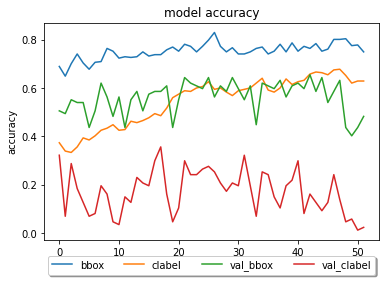

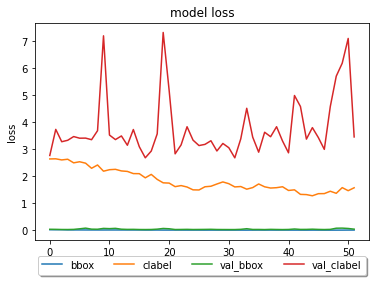


[INFO] Loading train images:  1 of 2 


[INFO] Trainig model

Epoch 1/100
11/11 [==============================] - 11s 1s/step - loss: 2.7333 - bounding_box_loss: 0.0219 - class_label_loss: 2.7115 - bounding_box_accuracy: 0.6753 - class_label_accuracy: 0.3103 - val_loss: 2.9039 - val_bounding_box_loss: 0.0190 - val_class_label_loss: 2.8849 - val_bounding_box_accuracy: 0.6207 - val_class_label_accuracy: 0.2989
Epoch 2/100
11/11 [==============================] - 11s 1s/step - loss: 2.6264 - bounding_box_loss: 0.0184 - class_label_loss: 2.6080 - bounding_box_accuracy: 0.6810 - class_label_accuracy: 0.3362 - val_loss: 2.8274 - val_bounding_box_loss: 0.0193 - val_class_label_loss: 2.8080 - val_bounding_box_accuracy: 0.6207 - val_class_label_accuracy: 0.2759
Epoch 3/100
11/11 [==============================] - 11s 1s/step - loss: 2.3465 - bounding_box_loss: 0.0144 - class_label_loss: 2.3321 - bounding_box_accuracy: 0.7270 - class_label_accuracy: 0.4023 - val_loss: 2.8219 - val_bounding_box

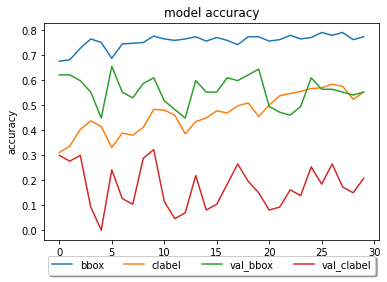

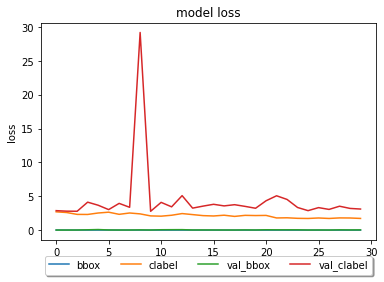

4/4 [==============================] - 1s 129ms/step - loss: 3.1588 - bounding_box_loss: 0.0311 - class_label_loss: 3.1277 - bounding_box_accuracy: 0.5780 - class_label_accuracy: 0.2752


<Figure size 432x288 with 0 Axes>

In [ ]:
train()